In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import matplotlib.cm as cm

import scipy
import scipy.cluster.hierarchy as sch
import time

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score
import skfuzzy as fuzz

from IPython.core.display import display, HTML
from datetime import datetime, timedelta
from rx import Observable, Observer
#import fastcluster as fc
from scipy.cluster.hierarchy import cophenet


pd.set_option('display.float_format', '{:.5g}'.format)

def getKey(item):
	return item[0]


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
def plotMatrix(matrix, title, s = None):
    if(s != None):
        print(s)
    plt.imshow(matrix, interpolation="nearest", cmap=cm.get_cmap('jet', 10), vmin=0, vmax=1)
    plt.grid(False)
    plt.title(title)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.show()
    

In [3]:
def loadData(s):
    ############### Carga datos
    df = pd.read_csv('data/Datos.csv',delimiter=';',index_col='Timestamp',decimal=',')
    df.index = pd.to_datetime(df.index)
    
    ############### retorna primeras 3 semanas
    dfSemanas=df.groupby(pd.TimeGrouper('W'))
    Historial=[]
    for W,(dateW,groupW) in enumerate(dfSemanas):
        if(W > 3):
            df=pd.concat(Historial)
            break
        Historial.append(groupW)
    print(df.shape)
    s['data'] = df 
    return s

In [4]:
############### Funcion de Cambio de matris de correlacion a distancia
def correlDist(corr):
    dist = ((1 - corr) / 2.)**.5
    return dist

def disInterCol(mov,Dis):
    disD=np.zeros((mov,mov))
    for i in range(mov):
        for j in range(mov):
            disD[i,j]=np.sqrt(np.sum((Dis[:,i]-Dis[:,j])**2.))
    return disD

def calcDataInfo(s):
    ############### Calculo de retornos
    rets = np.log(s['data']) - np.log(s['data'].shift(1))
    s['returns'] = rets.drop(rets.index[[0]])
    
    
    s['corr'] = corr = rets.corr()
    s['cov'] = cov = rets.cov()
    ## correlation matrix to distance matrix
    s['cmtdm'] = cmtdm = correlDist(corr).as_matrix()
    ## distance matrix between columns
    s['dmbc'] = disInterCol(corr.shape[0], cmtdm)

    return s

In [5]:

def fitt(D, C, algoritm, clusLib = 'sklearn'):
    if(clusLib == 'sklearn'):
        algoritm.n_clusters = C
        algoritm.fit(D)
        return algoritm.labels_.astype(np.int), None
    else:
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(D, C, 2, error=0.0005, maxiter=4000, init=None)
        return np.argmax(u, axis=0), fpc
    
def getMatrixCorr(y_pred, corr):
    idx1=[i[1] for i in sorted([[j,i] for i,j in enumerate(y_pred)], key=getKey)]
    Dtem=corr.as_matrix()
    Dtem = Dtem[idx1,:]
    Dtem = Dtem[:,idx1]
    return Dtem


############### Algoritmos


def fitPredict_AL(s, ncluster = 6):
    s['nameAl'] = name = 'AL'
    s['ncluster'] = ncluster
    s['metric'] = metric = 'precomputed'
    s['clusLib'] = 'sklearn'
    D = s['dmbc']

    algoritm = cluster.AgglomerativeClustering(linkage = "average", affinity = metric)
    s['y_pred'],_ = fitt(D, ncluster, algoritm)
    s['matrix_pred'] = getMatrixCorr(s['y_pred'], s['corr'])
    return s

def fitPredict_CL(s, ncluster = 10):
    s['nameAl'] = name = 'CL'
    s['ncluster'] = ncluster
    s['metric'] = metric = 'precomputed'
    s['clusLib'] = 'sklearn'
    D = s['dmbc']

    algoritm = cluster.AgglomerativeClustering(linkage = "complete", affinity = metric)
    s['y_pred'],_ = fitt(D, ncluster, algoritm)
    s['matrix_pred'] = getMatrixCorr(s['y_pred'], s['corr'])
    return s

def fitPredict_WM(s, ncluster = 10):
    s['nameAl'] = name = 'WM'
    s['ncluster'] = ncluster
    s['metric'] = metric = 'precomputed'
    s['clusLib'] = 'sklearn'
    D = s['dmbc']

    connectivity = kneighbors_graph(D, n_neighbors=10, include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)
    algoritm = cluster.AgglomerativeClustering(linkage = 'ward', connectivity = connectivity)
    s['y_pred'],_ = fitt(D, ncluster, algoritm)
    s['matrix_pred'] = getMatrixCorr(s['y_pred'], s['corr'])
    return s

def fitPredict_Fuzzy(s, ncluster = 8):
    s['nameAl'] = name = 'FUZZY'
    s['ncluster'] = ncluster
    s['metric'] = metric = 'precomputed'
    s['clusLib'] = 'fuzzy'
    D = s['dmbc']
    
    algoritm = None
    s['y_pred'], s['fpc'] = fitt(D, ncluster, algoritm, 'fuzzy')
    s['matrix_pred'] = getMatrixCorr(s['y_pred'], s['corr'])
    return s

######## Iterador de los algoritmos

def indexIterator(s):
    def addAtt(data,index):
        data['index'] = index
        return data
    return Observable.of(1,2,3,4) \
    .map(lambda i: addAtt(s,i))


def fitPredict(s):
    var = s['index']
    if(var == 1):
        s['fittFunction'] = fitPredict_AL
        return fitPredict_AL(s)
    
    elif(var == 2):
        s['fittFunction'] = fitPredict_CL
        return fitPredict_CL(s)
    
    elif(var == 3):
        s['fittFunction'] = fitPredict_WM
        return fitPredict_WM(s)
    
    elif(var == 4):
        s['fittFunction'] = fitPredict_Fuzzy
        return fitPredict_Fuzzy(s)

In [6]:
def calcCalinskiSilhouette(s):
    D = s['dmbc']
    metric = s['metric']
    fittFunc = s['fittFunction']
    s['n_clusters'] = n_clusters = [i for i in range(2,20,2)]
    
    paramet={}
    paramet['Silhouette Coefficient']=[]
    paramet['Calinski and Harabaz score']=[]
    if(s['index'] == 4):
        paramet['Fuzzy partition coefficient ']=[]
    
    for c in n_clusters:
        outFit = fittFunc(s.copy(), c)
        y_pred = outFit['y_pred'] 
        if(s['index'] == 4):
            fpc = outFit['fpc']
        
        calinski_score = calinski_harabaz_score(X=D, labels=y_pred)
        
        if(metric == 'precomputed'):
            silhouette_avg = silhouette_score(X=D, metric='precomputed', labels=y_pred)
        else:
            silhouette_avg = silhouette_score(X=D, labels=y_pred)

        paramet['Silhouette Coefficient'].append(silhouette_avg)
        paramet['Calinski and Harabaz score'].append(calinski_score)
        if(s['index'] == 4):
            paramet['Fuzzy partition coefficient '].append(fpc)
    
    s['dataCalinskiSilhouette'] = paramet
    return s


def plotScoresCalinskiSilhouette(s):
    ncluster = s['ncluster']
    paramet = s['dataCalinskiSilhouette']
    clusLib = s['clusLib']
    n_clusters = s['n_clusters']

    for i,cu in enumerate(paramet):
        x=n_clusters
        y=paramet[cu]

        if(clusLib != 'sklearn'):
            plt.figure(figsize=(5,6))
            plt.subplot(311+i)
        else:
            plt.figure(figsize=(5,4))
            plt.subplot(211+i)
        plt.title(cu)
        plt.grid(True)
        plt.xlabel('#Clusters')
        plt.ylabel('Score')
        plt.plot(x,y)
        plt.axvline(x=ncluster, color="red", linestyle="--")

    plt.tight_layout()
    plt.show()


In [7]:
def plotSiluet(s,var=True,title=''):
    D, y_pred = s['dmbc'], s['y_pred']
    metric = s['metric']
    ncluster = s['ncluster']
    
    if(var):
        plt.figure()
    ##### Define si la metrica es precomputada
    if(metric=='precomputed'):
        silhouette_avg = silhouette_score(X=D,metric='precomputed',labels=y_pred)
        sample_silhouette_values = silhouette_samples(X=D,metric='precomputed',labels=y_pred)
    else:
        silhouette_avg = silhouette_score(X=D,labels=y_pred)
        sample_silhouette_values = silhouette_samples(X=D,labels=y_pred)


    calinski_score = calinski_harabaz_score(X=D, labels=y_pred)

    plt.xlim([-1, 1])
    plt.ylim([0, y_pred.shape[0] + (ncluster + 1) * 10])
    y_lower = 10

    for i in range(ncluster):
        ith_cluster_silhouette_values = sample_silhouette_values[y_pred == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / ncluster)
        
        plt.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.grid(True)
    plt.xticks([-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1],rotation=45)
    plt.xlim([-0.4, 0.8])
    plt.title(title)

    if(var):
        plt.title('Silhouette Coefficient for each sample')
        plt.show()
    return None

(7820, 175)


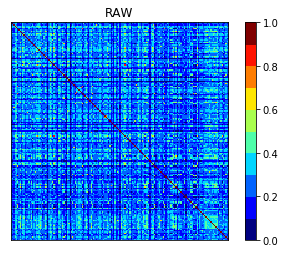

6


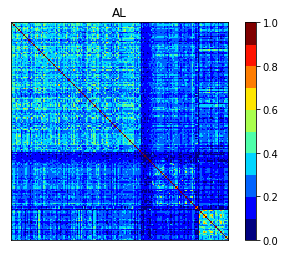

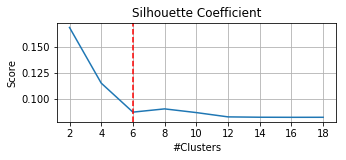

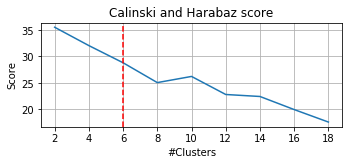

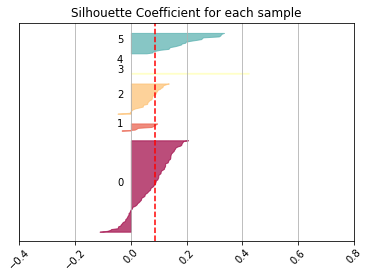

10


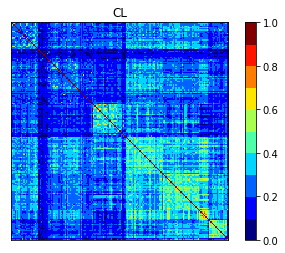

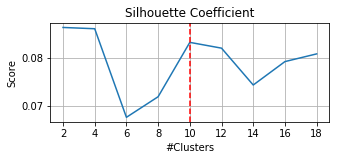

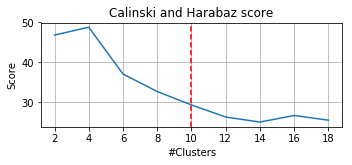

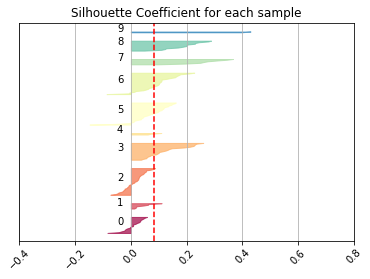

10


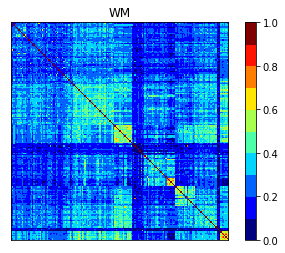

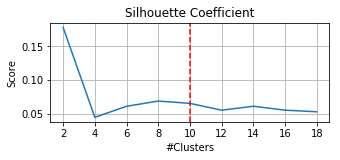

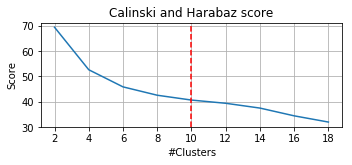

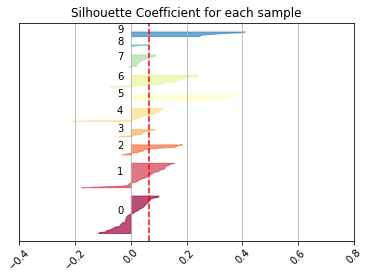

8


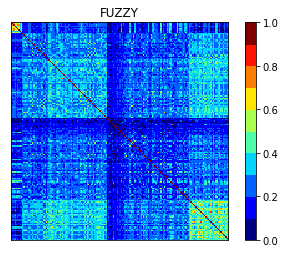

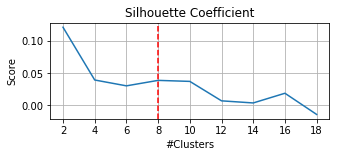

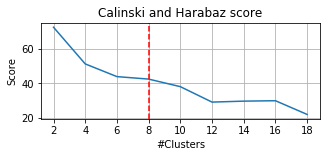

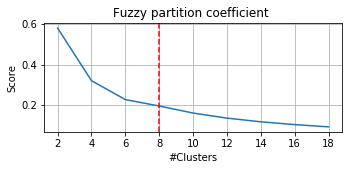

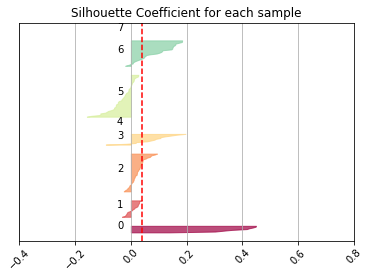

In [8]:
def func(s):
    #for key, value in s.items():
    #    print(key)
    #print(s['y_pred'])
    pass
    
Observable.of({}) \
.map(lambda s: loadData(s)) \
.map(lambda s: calcDataInfo(s)) \
.do_action(lambda s: plotMatrix(s['corr'], 'RAW')) \
.flat_map(lambda s: indexIterator(s)) \
.map(lambda s: fitPredict(s)) \
.map(lambda s: calcCalinskiSilhouette(s)) \
.do_action(lambda s: plotMatrix(s['matrix_pred'], s['nameAl'], s['ncluster'])) \
.do_action(lambda s: plotScoresCalinskiSilhouette(s)) \
.do_action(lambda s: plotSiluet(s,var=True,title=s['nameAl'])) \
.subscribe(lambda s: func(s))
#input("Press any key to quit\n")


In [9]:
s={}
s=loadData(s)
s=calcDataInfo(s)
print(s['returns'])

(7820, 175)
                            ABT         ACN      ADBE.O         ADM  \
Timestamp                                                             
2016-09-12 08:32:00  0.00048912  -0.0011246  -0.0011095  -0.0013517   
2016-09-12 08:33:00   0.0012217   0.0012624  0.00070618  0.00095717   
2016-09-12 08:34:00   0.0005493   0.0013658  0.00070568   0.0026275   
2016-09-12 08:35:00  0.00067096   0.0012663  0.00012596  -0.0011529   
2016-09-12 08:36:00  -0.0019531  -0.0011758  0.00037779  0.00067565   
2016-09-12 08:37:00           0  0.00099498   0.0018114  0.00023864   
2016-09-12 08:38:00   -0.000978  -0.0014928 -0.00030167  -0.0023889   
2016-09-12 08:39:00   0.0017109 -0.00031695  0.00010057 -0.00047847   
2016-09-12 08:40:00  0.00024417   0.0034358   0.0009338   0.0026288   
2016-09-12 08:41:00 -0.00024417  -0.0010837 -0.00053162  -0.0019111   
2016-09-12 08:42:00  0.00097632   0.0018957   0.0012055   0.0007171   
2016-09-12 08:43:00 -0.00048804  -0.0019861 -0.00050213 -0.000478

In [10]:
X = s['returns'].values.copy()  # Original data (1000 observations)
Z = fc.linkage_vector(X)         # Clustering

orign_dists = fc.pdist(X)  # Matrix of original distances between observations
cophe_dists = cophenet(Z)  # Matrix of cophenetic distances between observations

# What I really want at the end of the day is
corr_coef = np.corrcoef(orign_dists, cophe_dists)[0,1]
corr_coef

NameError: name 'fc' is not defined

In [11]:
print(X.shape)
print(Z.shape)

(7819, 175)


NameError: name 'Z' is not defined

In [12]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage

In [13]:
Z = linkage(X, 'ward')
c, coph_dists = cophenet(Z, pdist(X))
c

0.15742930880564726

In [14]:

coph_dists.shape

(30564471,)

In [15]:
Z = linkage(X, 'average')
c, coph_dists = cophenet(Z, pdist(X))
c

0.97463001580945319

In [16]:
Z = linkage(X, 'complete')
c, coph_dists = cophenet(Z, pdist(X))
c

0.52722558505330841

In [17]:

directory='dataOutSim/fuzzC'+str(2)
if not os.path.exists(directory):
    os.makedirs(directory)

NameError: name 'os' is not defined